# Centered Kernel Alignment (CKA)

This script shows how to calculate CKA for the deep proprioceptive models, based on Kornblith et al 2019: https://arxiv.org/abs/1905.00414

This script should be run using the libraries from the environment.yml file.

In [7]:
import numpy as np
from kornblith_et_al_rsa_colab import *
from rowwise_neuron_curves import lstring
import seaborn as sns
import os, pickle
import copy
import matplotlib.pyplot as plt
import matplotlib
from main import RunInfo
from rowwise_neuron_curves import lstring, read_layer_reps

def cca(features_x, features_y):
    """Compute the mean squared CCA correlation (R^2_{CCA}).
    From: Kornblith et al 2019

    Args:
      features_x: A num_examples x num_features matrix of features.
      features_y: A num_examples x num_features matrix of features.

    Returns:
      The mean squared CCA correlations between X and Y.
      
    """
    qx, _ = np.linalg.qr(features_x)  # Or use SVD with full_matrices=False.
    qy, _ = np.linalg.qr(features_y)
    return np.linalg.norm(qx.T.dot(qy)) ** 2 / min(features_x.shape[1], features_y.shape[1])

Specify model and run info

In [8]:
modelinfo = dict({'type': 'S',
        'typename': 'spatial_temporal',
        'base': 'spatial_temporal_4_8-16-16-32_32-32-64-64_7293',
        'base_regression': 'spatial_temporal_r_4_8-16-16-32_32-32-64-64_7293',
        'nlayers': 8,
        'max_nlayers': 8,
        'max_act': 14, #this can be manually adjusted as the maximum in the preferred direction histogram
        'control': False,
        'cmap': matplotlib.colors.ListedColormap(['midnightblue']),
        'color': 'midnightblue',
        'regression_color': 'darkturquoise',
        'control_cmap': 'Greys_r',
        'regression_cmap': matplotlib.colors.ListedColormap(['darkturquoise']),
        's_stride': 2,
        't_stride': 3,
        'regression_task': False,
        'model_path': None,
        'exp_id': None,})

runinfo = RunInfo({'expid': 402, #internal experiment id
                   'datafraction': 'auto',  #fraction (0,1] or 'auto' (i.e. if you want to run a new analysis but keep the old results that it would otherwise overwrite, increment by 1)
                   'randomseed': 2000,
                   'randomseed_traintest': 42,
                   'dirr2threshold': 0.2,
                   'verbose': 2, #0 (least), 1, 2 (most)
                   'model_experiment_id': 22,  #used in model training, int or 'auto'
                   'basefolder': '/media/data/DeepDraw/revisions/analysis-data/', ## change this folder to redirect to where the data is saved locally
                   'batchsize': 100, #for layer representation generation
                   'default_run': True, #only variable that is 'trial'-dependent,
                                    #ie should be changed when rerunning stuff in same folder
                                    #not semantically important for run info
                    'dpi': 500
            })

internal vars

In [9]:
n_instantiations = 5

perform comparisons

In [10]:
nlayers = modelinfo['nlayers']

cka_matrix = np.zeros((n_instantiations, nlayers + 1))

for iinsta in np.arange(0,n_instantiations):
    
    trainedmodel = modelinfo.copy()
    trainedmodel['name'] = modelinfo['base'] + '_%d' %(iinsta+1)

    controlmodel = modelinfo.copy()
    controlmodel['name'] = modelinfo['base'] + '_%dr' %(iinsta+1)

    for ilayer in np.arange(-1, nlayers):
        layer = lstring(ilayer)  
        X = read_layer_reps(ilayer, runinfo, trainedmodel)
        X = X.reshape((X.shape[0], -1))                    
        Y = read_layer_reps(ilayer, runinfo, controlmodel)
        Y = Y.reshape((Y.shape[0], -1))

        cka_from_examples = cka(gram_linear(X), gram_linear(Y))

        cka_matrix[iinsta, ilayer + 1] = cka_from_examples

read layer represenations. shape:  (4000, 25, 320, 2)
read layer represenations. shape:  (4000, 25, 320, 2)
read layer represenations. shape:  (4000, 13, 320, 8)
read layer represenations. shape:  (4000, 13, 320, 8)
read layer represenations. shape:  (4000, 7, 320, 16)
read layer represenations. shape:  (4000, 7, 320, 16)
read layer represenations. shape:  (4000, 4, 320, 16)
read layer represenations. shape:  (4000, 4, 320, 16)
read layer represenations. shape:  (4000, 2, 320, 32)
read layer represenations. shape:  (4000, 2, 320, 32)
read layer represenations. shape:  (4000, 2, 107, 32)
read layer represenations. shape:  (4000, 2, 107, 32)
read layer represenations. shape:  (4000, 2, 36, 32)
read layer represenations. shape:  (4000, 2, 36, 32)
read layer represenations. shape:  (4000, 2, 12, 64)
read layer represenations. shape:  (4000, 2, 12, 64)
read layer represenations. shape:  (4000, 2, 4, 64)
read layer represenations. shape:  (4000, 2, 4, 64)
read layer represenations. shape:  (

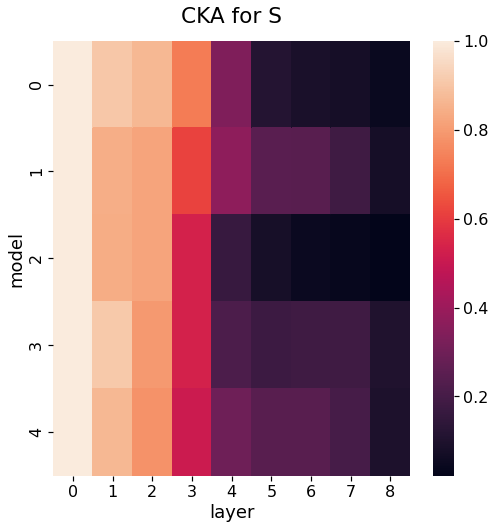

In [15]:
fig = plt.figure()
cka_ax = sns.heatmap(cka_matrix)
cka_ax.set_xlabel('layer')
cka_ax.set_ylabel('model')
cka_ax.set_title('CKA for %s' %modelinfo['type'])
fig = cka_ax.get_figure()
fig